In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from src.models import TadGAN, AttentionTadGAN
from src.processor import AnomalyDataset
from mlprimitives import load_primitive
from src.configuration.constants import REPORTS_DIRECTORY, MODELS_DIRECTORY
from orion.evaluation.contextual import contextual_f1_score, contextual_confusion_matrix
import pickle
import json

import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def get_epoch_loss(source, dataset, signal, model_name):
    with open(os.path.join(MODELS_DIRECTORY, source, dataset, signal, model_name, 'input_parameters.json'), 'rb') as f:
        input_parameters = json.load(f)
    return np.array(input_parameters['epoch_loss'])
    

def plot_losses(tadgan_loss, attention_tadgan_loss, output_directory):
    fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharey=False, sharex=True)

    epoch_loss_names = [
        ['valid_x_wasserstein_loss', 'fake_x_wasserstein_loss', 'partial_gp_loss_x', 'weighted_loss'],
        ['valid_z_wasserstein_loss', 'fake_z_wasserstein_loss', 'partial_gp_loss_z', 'weighted_loss'],
        ['fake_gen_x_wasserstein_loss', 'fake_gen_z_wasserstein_loss', 'mse', 'weighted_loss'],
    ]
    
    num_epoch, num_model, num_loss = tadgan_loss.shape

    index = [epoch for epoch in range(num_epoch)]
    for i in range(num_model):
        for j in range(num_loss):
            axs[i][j].set_title(epoch_loss_names[i][j])
            axs[i][j].plot(index, tadgan_loss[:, i, j], label='tadgan', color='b')
            axs[i][j].plot(index, attention_tadgan_loss[:, i, j], label='attention_tadgan', color='r')

    fig.suptitle(f'[{source}] [{dataset}] [{signal}] Epoch losses', fontsize=16)
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.savefig(os.path.join(output_directory, 'epoch_losses.png'))

In [3]:
def get_anomalies(y_test, y_hat, critic, index_test):
    params = {"rec_error_type": "dtw", "comb": "mult"}

    primitive = load_primitive("orion.primitives.tadgan.score_anomalies", 
                               arguments=params)
    errors, true_index, true, predictions = primitive.produce(y=y_test, y_hat=y_hat, critic=critic, index=index_test)
    
    params = {
    "window_size_portion": 0.33, 
    "window_step_size_portion": 0.1,
    "fixed_threshold": True
    }

    primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                               arguments=params)
    predicted_anomalies = primitive.produce(errors=errors, index=true_index)
    predicted_anomalies = [(int(anomaly[0]), int(anomaly[1])) for anomaly in predicted_anomalies]
    return predicted_anomalies

def calculate_confusion_matrix(model_name, anomalies, y_test, index_test):
    output_directory = os.path.join(MODELS_DIRECTORY, source, dataset, signal, model_name)
    with open(os.path.join(output_directory, 'y_hat_test.npy'), 'rb') as f:
        y_hat = np.load(f)
    with open(os.path.join(output_directory, 'critic_test.npy'), 'rb') as f:
        critic = np.load(f)
    
    predicted_anomalies = get_anomalies(y_test, y_hat, critic, index_test)
    
    # true negative, false positive, false negative, true positive
    confusion_matrix = contextual_confusion_matrix(
        anomalies, 
        predicted_anomalies, 
        start=index_test[0], 
        end=index_test[-1], 
        weighted=False
    )
    return [predicted_anomalies, confusion_matrix]

  0%|          | 0/27 [00:00<?, ?it/s]

M-5
M-2
C-2
M-3
M-4
F-8
T-12
P-14
F-7
P-15
D-16
T-13
T-8
T-9
M-1
M-6
M-7
C-1
S-2
D-14
P-10


/Users/lcwong/opt/anaconda3/envs/hitlads-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


F-5
P-11
D-15
F-4
T-5
T-4


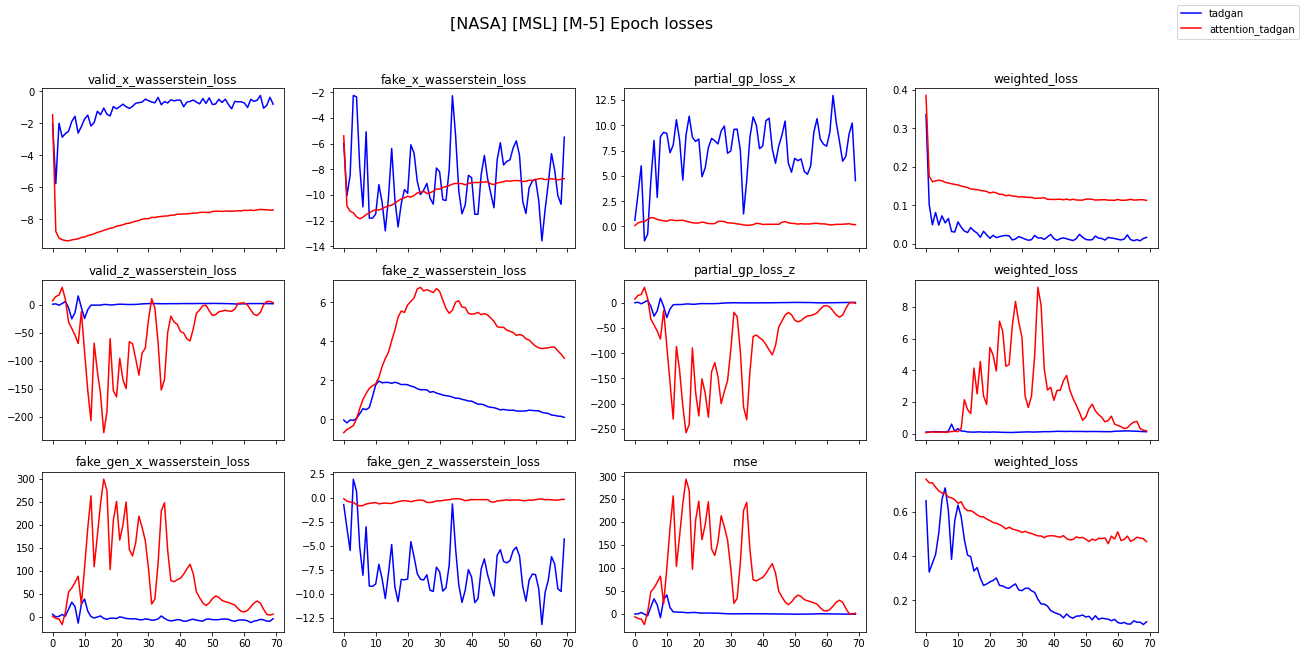

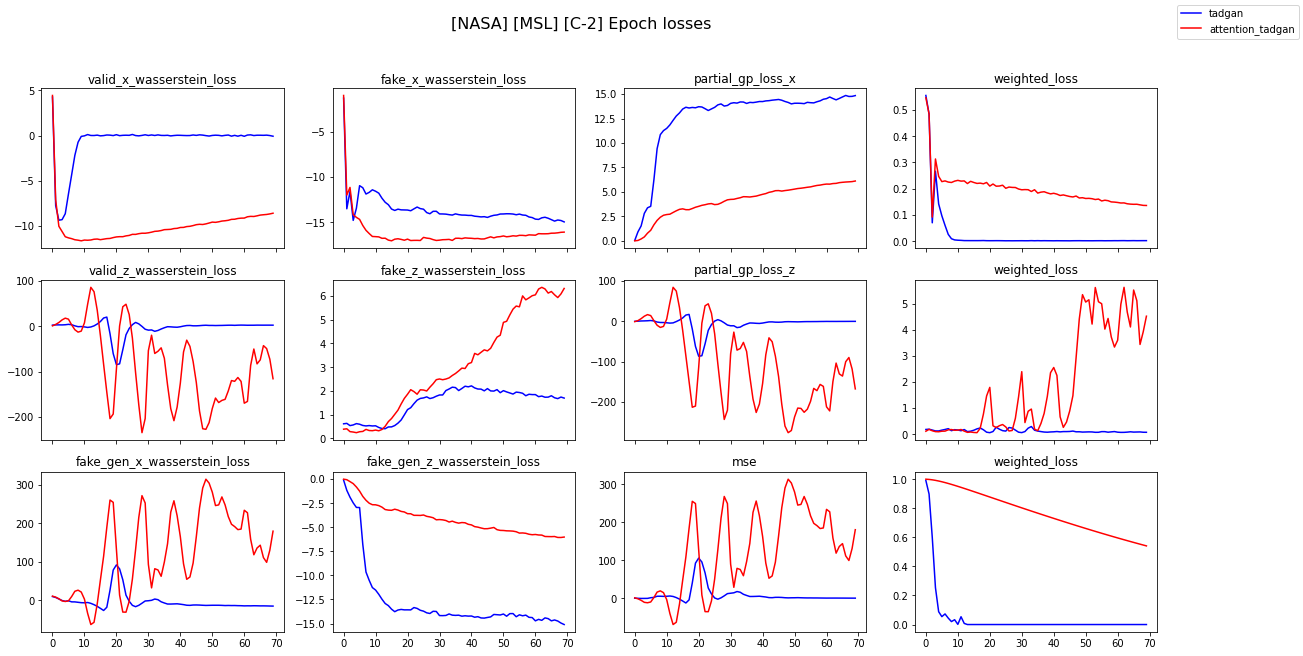

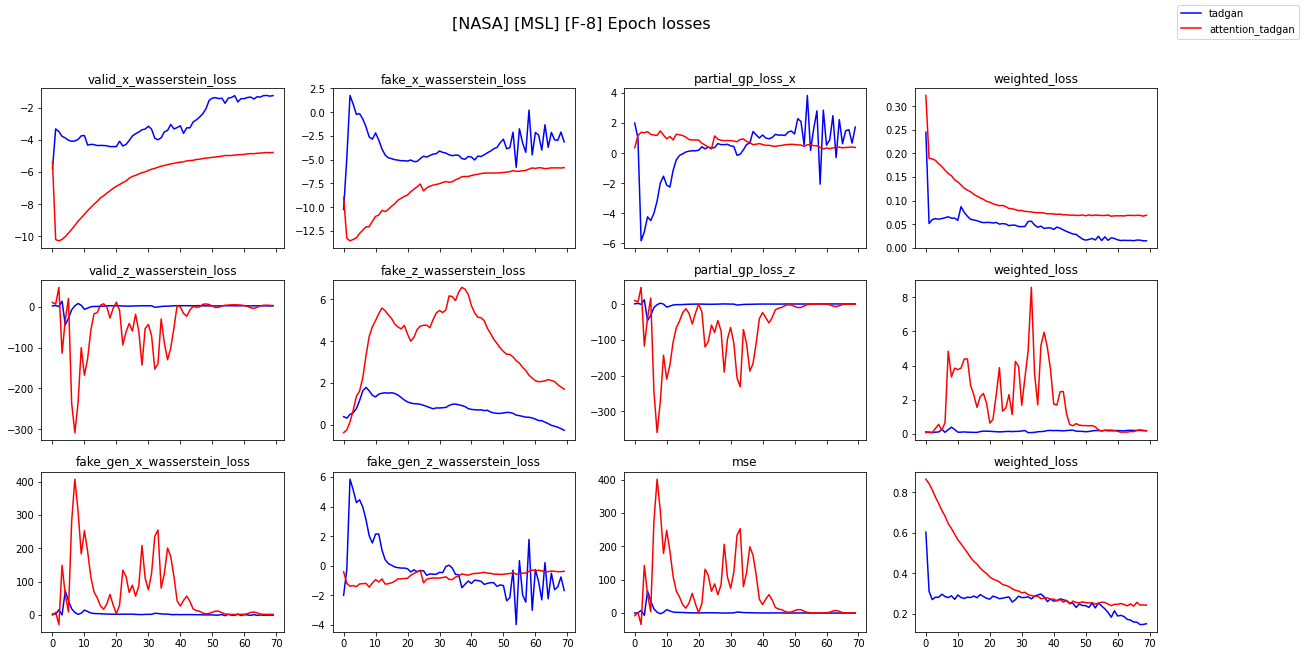

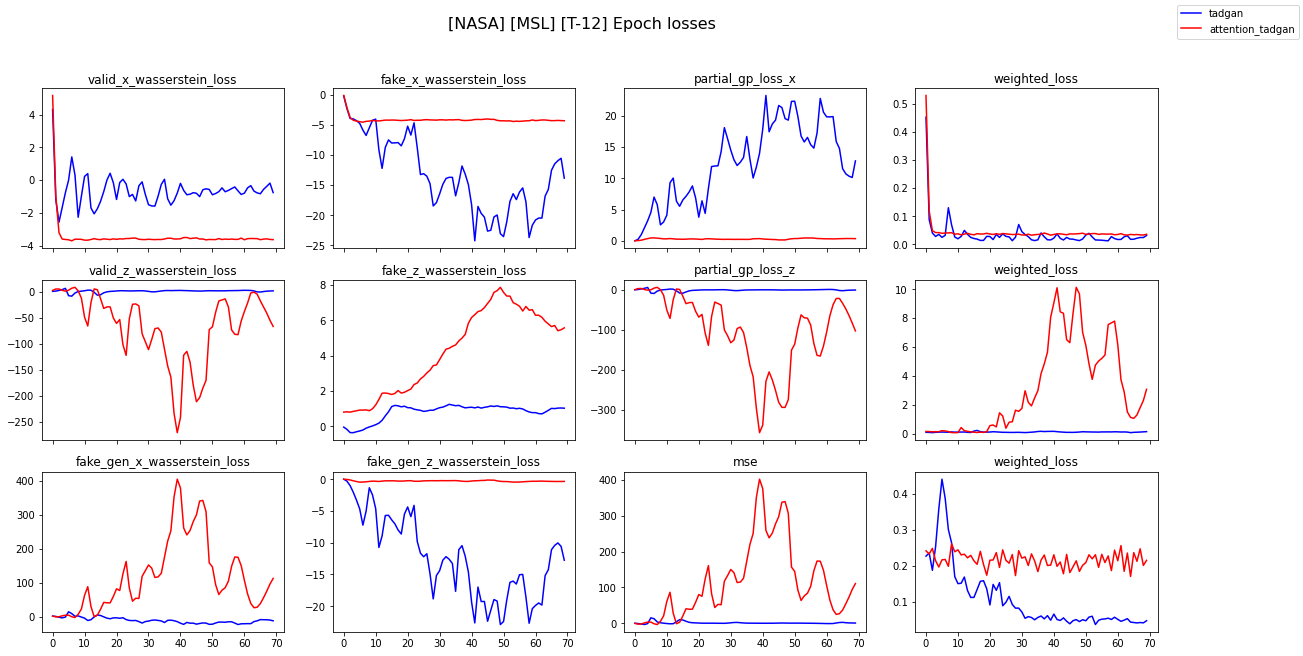

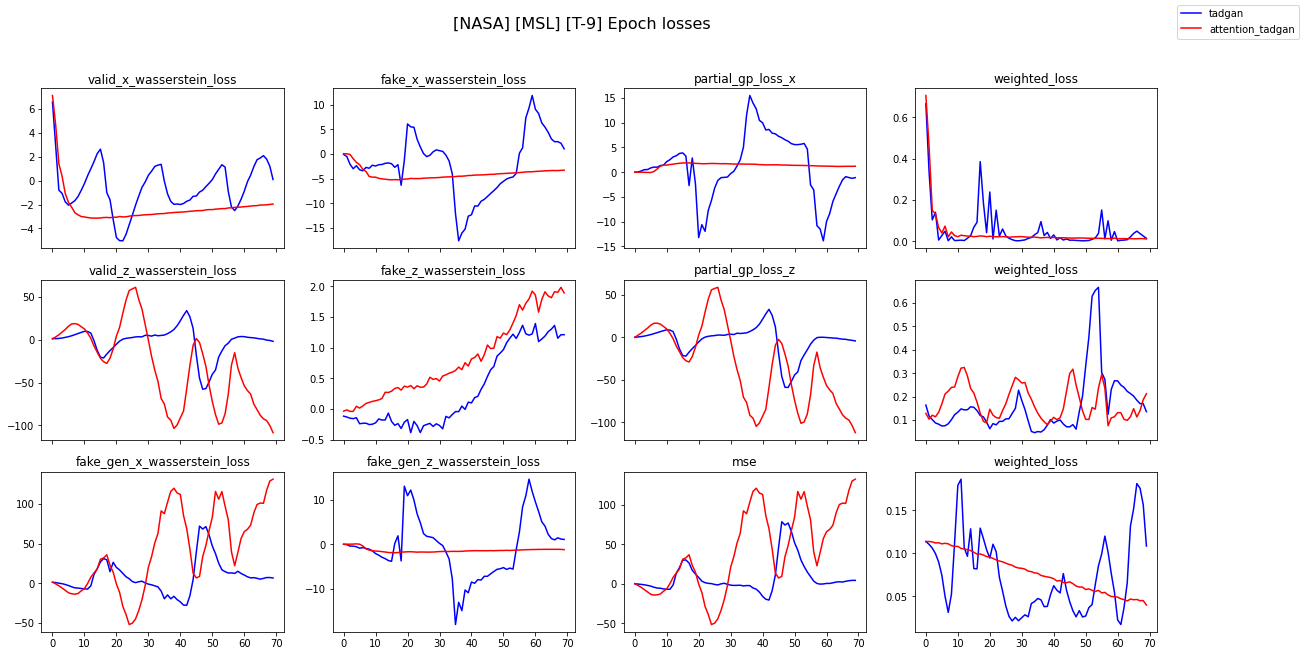

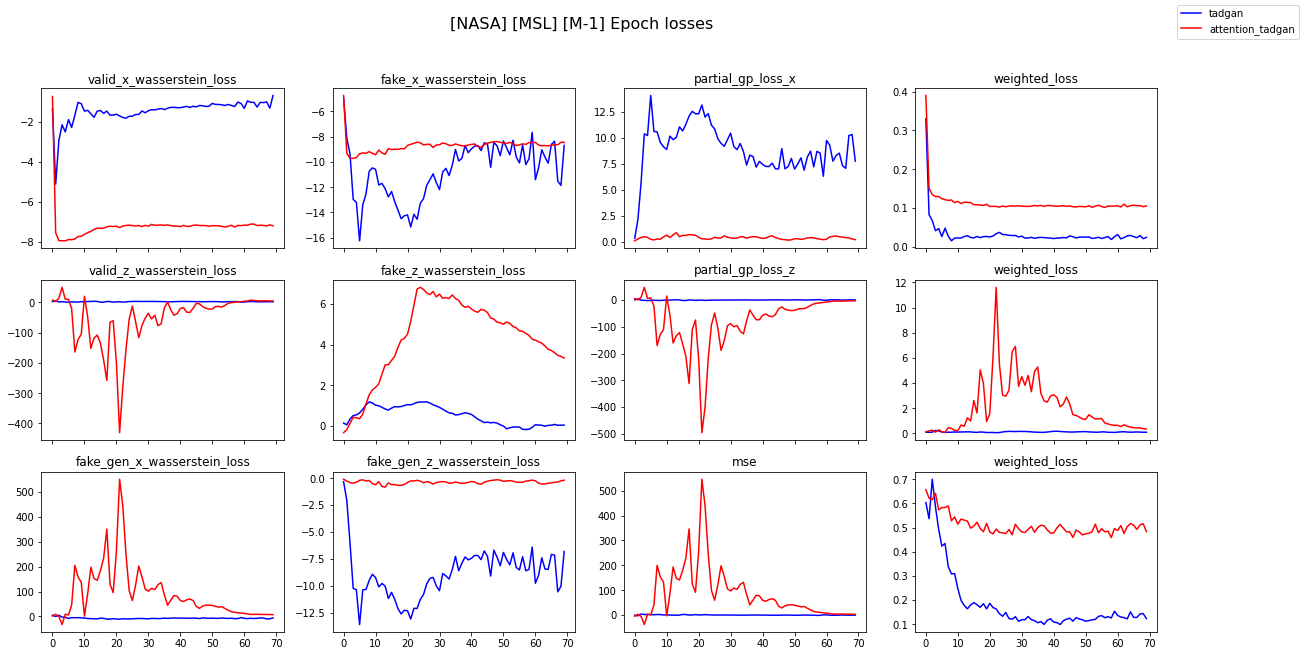

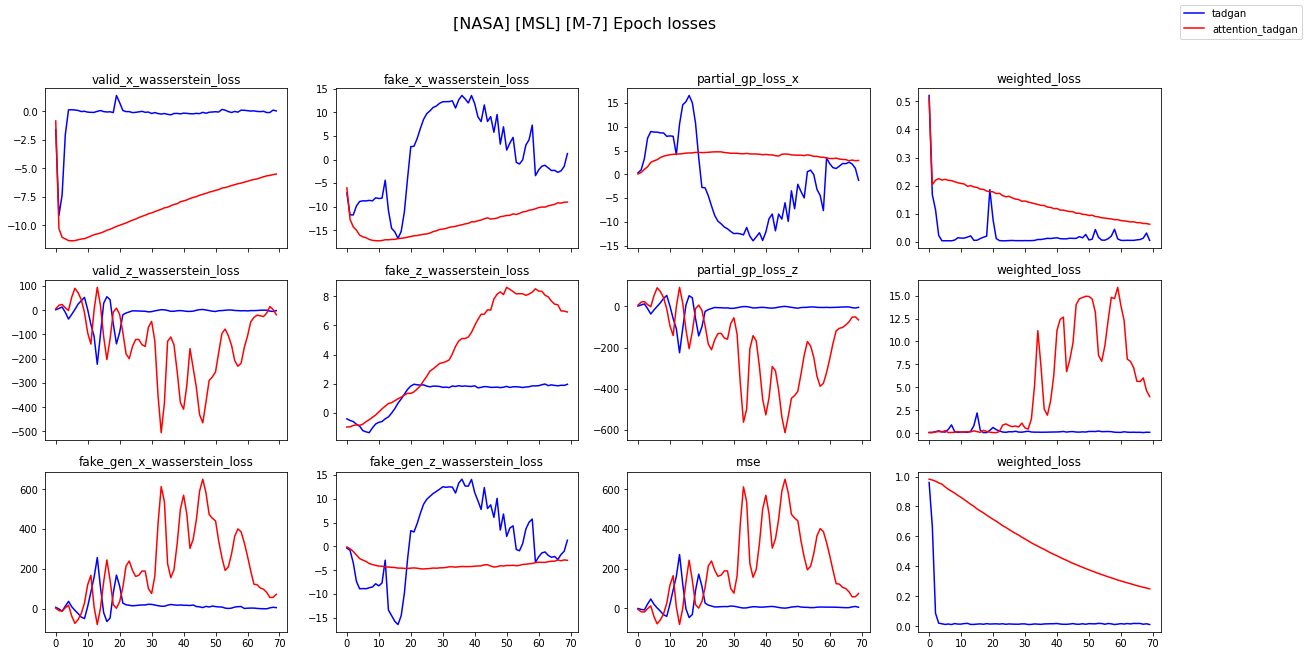

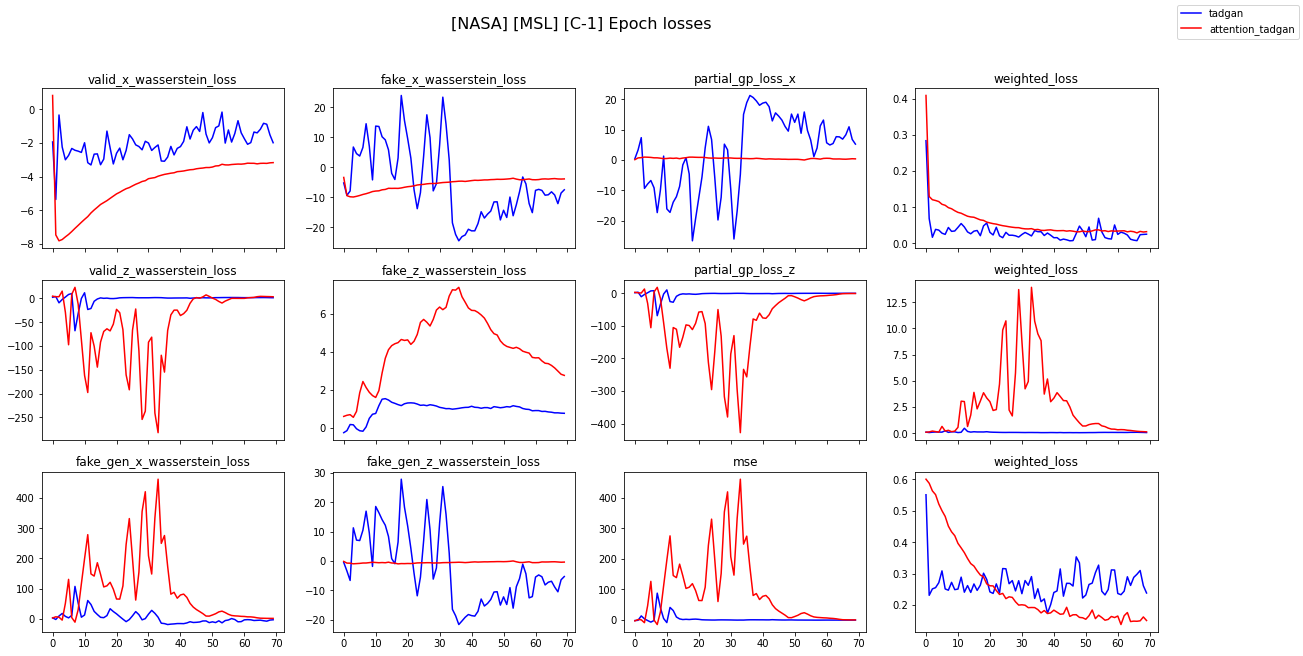

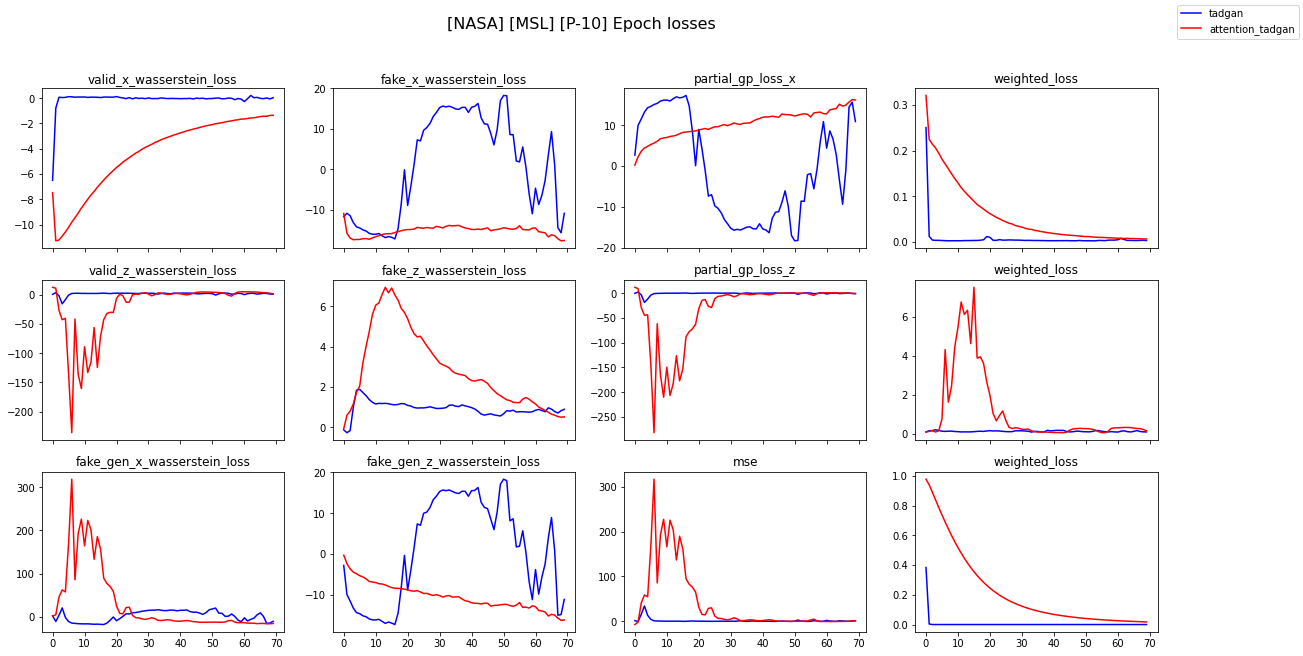

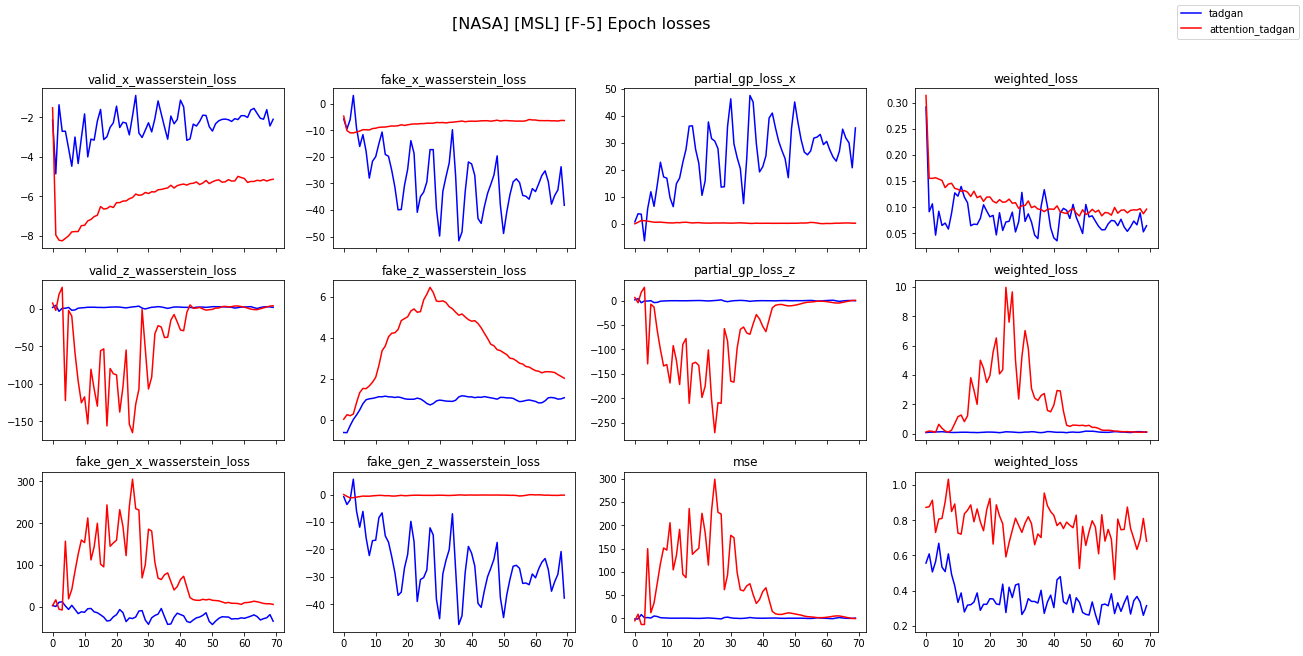

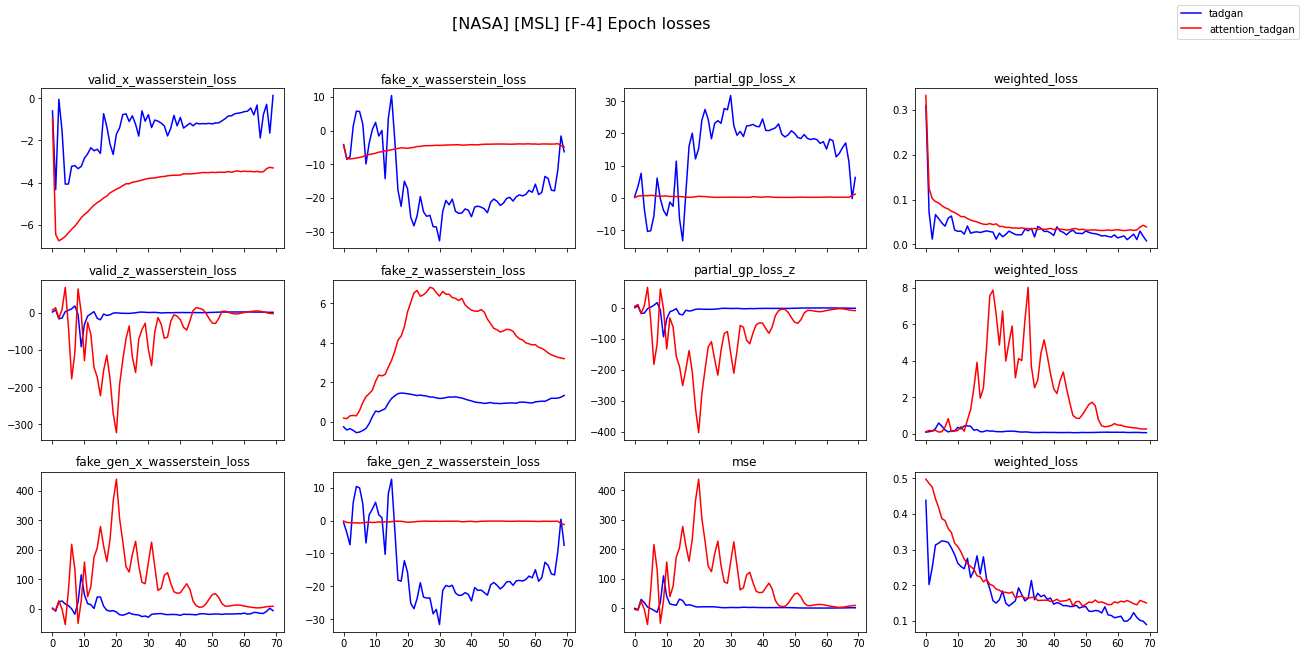

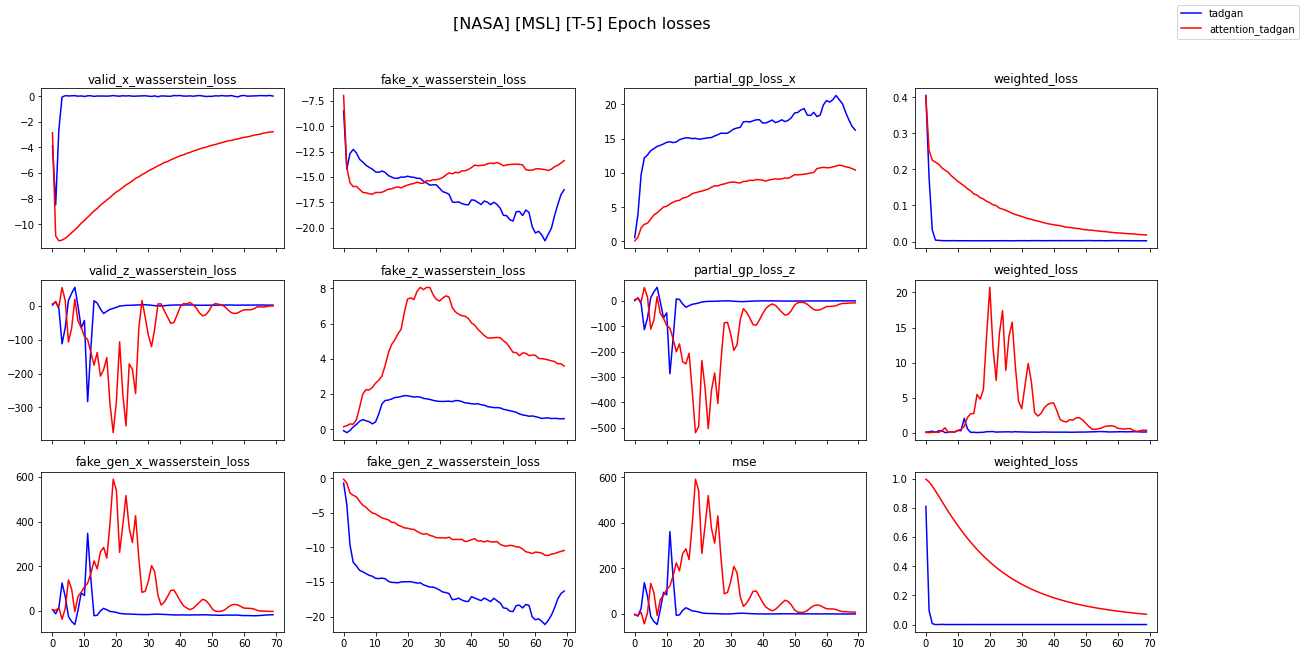

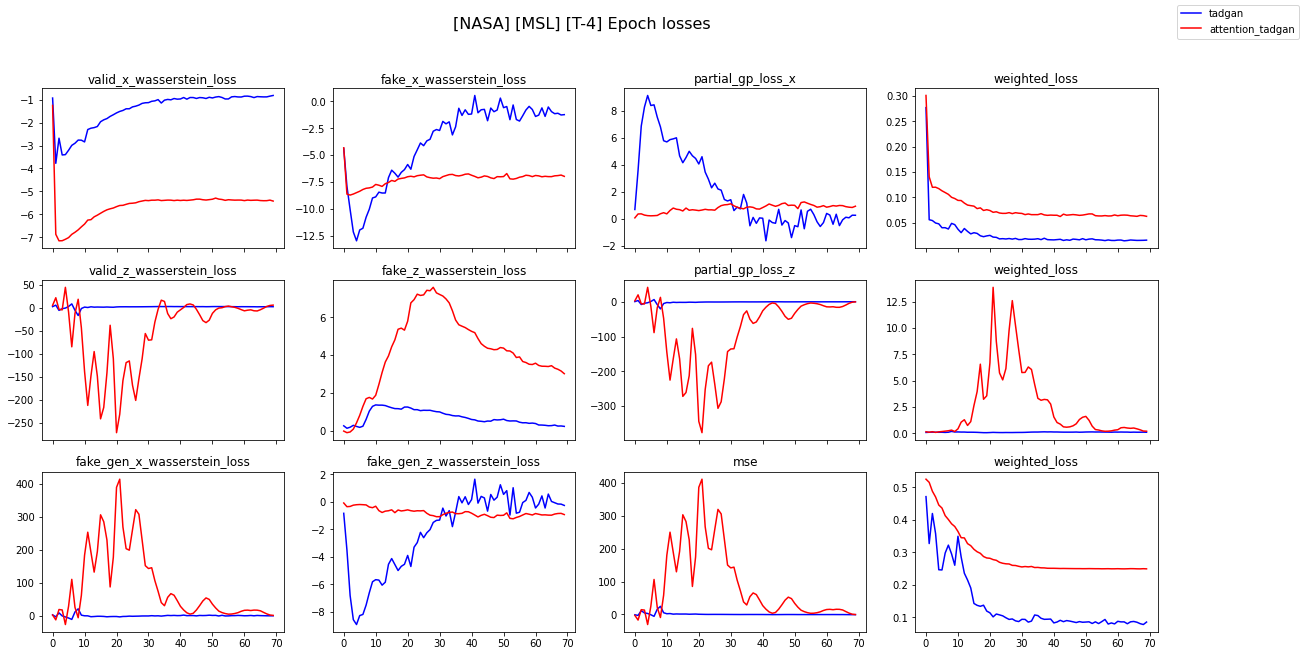

In [5]:
source = 'NASA'
dataset = 'MSL'
columns = ['source', 'dataset', 'signal', 'ground_truth', 'tadgan_pp', 'tadgan_cm', 'attention_tadgan_pp', 'attention_tadgan_cm']

signals = AnomalyDataset.get_signals(source, dataset)
signals_summary = []

for signal in tqdm(signals):
    print(signal)

    model_epoch_loss = []
    model_epoch_loss.append(get_epoch_loss(source, dataset, signal, TadGAN.model_name))
    model_epoch_loss.append(get_epoch_loss(source, dataset, signal, AttentionTadGAN.model_name))

    output_directory = os.path.join(REPORTS_DIRECTORY, source, dataset, signal)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plot_losses(model_epoch_loss[0], model_epoch_loss[1], output_directory)

    anomaly_dataset = AnomalyDataset.load(source, dataset, signal)
    summary = [source, dataset, signal]
    summary.append(anomaly_dataset.test.anomalies.values)
    summary.extend(calculate_confusion_matrix(
        TadGAN.model_name, 
        anomaly_dataset.test.anomalies,
        anomaly_dataset.test.y_processed, 
        list(anomaly_dataset.test.index)
    ))
    summary.extend(calculate_confusion_matrix(
        AttentionTadGAN.model_name, 
        anomaly_dataset.test.anomalies,
        anomaly_dataset.test.y_processed, 
        list(anomaly_dataset.test.index)
    ))
    signals_summary.append(summary)

In [6]:
summary_df = pd.DataFrame(signals_summary, columns=columns)
summary_df.to_csv(os.path.join(REPORTS_DIRECTORY, source, dataset, 'summary.csv'), index=False)

In [16]:
summary_df

source dataset signal                                ground_truth  \
0    NASA     MSL    M-5                              [[1250, 1550]]   
1    NASA     MSL    M-2                              [[1110, 2250]]   
2    NASA     MSL    C-2                  [[290, 390], [1540, 1575]]   
3    NASA     MSL    M-3                              [[1250, 1500]]   
4    NASA     MSL    M-4                              [[1250, 1500]]   
5    NASA     MSL    F-8                              [[1950, 2486]]   
6    NASA     MSL   T-12                                [[630, 750]]   
7    NASA     MSL   P-14                              [[4575, 4755]]   
8    NASA     MSL    F-7  [[1250, 1450], [2670, 2790], [3325, 3425]]   
9    NASA     MSL   P-15                              [[1390, 1410]]   
10   NASA     MSL   D-16                               [[600, 1250]]   
11   NASA     MSL   T-13                  [[690, 790], [1900, 2050]]   
12   NASA     MSL    T-8                  [[870, 930], [1330, 1370]]   
13   NASA     MSL    T-9                    [[780, 810], [890, 970]]   
14   NASA     MSL    M-1                              [[1110, 2250]]   
15   NASA     MSL    M-6                              [[1850, 2030]]   
16   NASA     MSL    M-7                               [[940, 1040]]   
17   NASA     MSL    C-1                  [[550, 750], [2100, 2210]]   
18   NASA     MSL    S-2                                [[900, 910]]   
19   NASA     MSL   D-14                [[1630, 1650], [1800, 2000]]   
20   NASA     MSL   P-10                              [[4590, 4720]]   
21   NASA     MSL    F-5                              [[3550, 3700]]   
22   NASA     MSL   P-11                [[1778, 1898], [1238, 1344]]   
23   NASA     MSL   D-15                              [[1500, 2140]]   
24   NASA     MSL    F-4                              [[2700, 2770]]   
25   NASA     MSL    T-5                              [[1200, 1225]]   
26   NASA     MSL    T-4                              [[1172, 1240]]   

                                            tadgan_pp        tadgan_cm  \
0                        [(1458, 1565), (1908, 1975)]  (None, 1, 0, 1)   
1                                      [(1153, 1207)]  (None, 0, 0, 1)   
2                                      [(1393, 1493)]  (None, 1, 2, 0)   
3                                        [(426, 501)]  (None, 1, 1, 0)   
4                                        [(362, 475)]  (None, 1, 1, 0)   
5             [(343, 463), (911, 1032), (1924, 2063)]  (None, 2, 0, 1)   
6                         [(969, 1084), (1539, 1596)]  (None, 2, 1, 0)   
7                                      [(4557, 4638)]  (None, 0, 0, 1)   
8   [(1321, 1473), (2669, 2794), (3316, 3444), (35...  (None, 1, 0, 3)   
9                                      [(1358, 1417)]  (None, 0, 0, 1)   
10                           [(658, 722), (803, 871)]  (None, 0, 0, 1)   
11                                     [(2343, 2428)]  (None, 1, 2, 0)   
12  [(187, 294), (360, 463), (795, 857), (1320, 14...  (None, 3, 1, 1)   
13                [(74, 131), (710, 768), (841, 916)]  (None, 2, 1, 1)   
14         [(1064, 1194), (1292, 1362), (2161, 2267)]  (None, 0, 0, 1)   
15                                     [(1823, 1899)]  (None, 0, 0, 1)   
16                          [(187, 302), (917, 1065)]  (None, 1, 0, 1)   
17                                                 []  (None, 0, 2, 0)   
18                                       [(850, 972)]  (None, 0, 0, 1)   
19                       [(1582, 1704), (1764, 1822)]  (None, 0, 0, 2)   
20                                     [(4552, 4638)]  (None, 0, 0, 1)   
21                                     [(3548, 3633)]  (None, 0, 0, 1)   
22  [(1205, 1361), (1788, 1923), (2676, 2809), (31...  (None, 2, 0, 2)   
23                                       [(281, 387)]  (None, 1, 1, 0)   
24                                     [(2046, 2169)]  (None, 1, 1, 0)   
25                                     [(1120, 1310)]  (None, 

In [28]:
values = []
for i in summary_df.tadgan_cm:
    v = []
    for j in i:
        if j is None:
            v.append(0)
        else:
            v.append(j)
    values.append(v)
tadgan_cm = np.array(values).sum(axis=0)
print(tadgan_cm)

tn, fp, fn, tp = tadgan_cm

f1 = tp / (tp + .5 * (fp + fn))
f1

[ 0 21 14 22]


0.5569620253164557

In [30]:
values = []
for i in summary_df.attention_tadgan_cm:
    v = []
    for j in i:
        if j is None:
            v.append(0)
        else:
            v.append(j)
    values.append(v)
attnetion_tadgan_cm = np.array(values).sum(axis=0)
print(attnetion_tadgan_cm)

tn, fp, fn, tp = attnetion_tadgan_cm

f1 = tp / (tp + .5 * (fp + fn))
f1

[ 0 20  9 27]


0.6506024096385542